In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys

sys.path.append("/notebooks/JAXGym")

In [18]:
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '__editable__.flax-0.8.2.finder.__path_hook__',
 '/opt/pip/src',
 '/opt/praxis',
 '/opt/paxml',
 '/usr/lib/python3/dist-packages',
 '/notebooks/JAXGym',
 '/notebooks/JAXGym']

In [19]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [20]:
from models.base_model import BaseModel
from agents.REINFORCE_discrete import ActorCriticDiscrete
from trainer import build_trainer

In [21]:
actor_lr = 1e-4
critic_lr = 1e-3

discount = 0.99

iters = 10000

max_episode_steps = 500

env_name = "CartPole-v1"

In [22]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).n

In [23]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(cpu_device):
    key = jax.random.PRNGKey(42)
    
    dummy = jnp.ones([1, obs_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(), nn.Dense(features = action_size)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseModel(), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = ActorCriticDiscrete(discount)
    
    all_rewards = jnp.zeros((iters, 1))
    
    fori_body = build_trainer(agent, env, env_params, obs_size, max_episode_steps)
    
    carry = (actor, critic, all_rewards, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

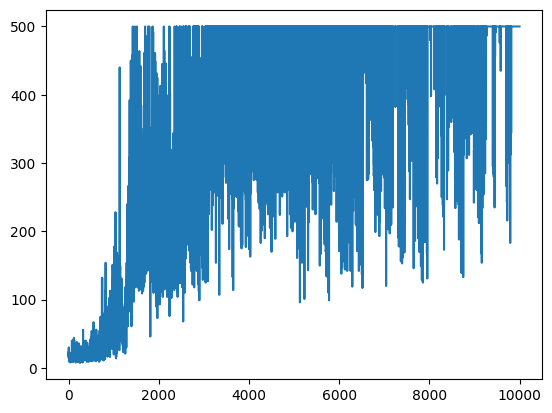

In [24]:
plt.plot(carry[-2][:])
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
MovieWriter imagemagick unavailable; using Pillow instead.


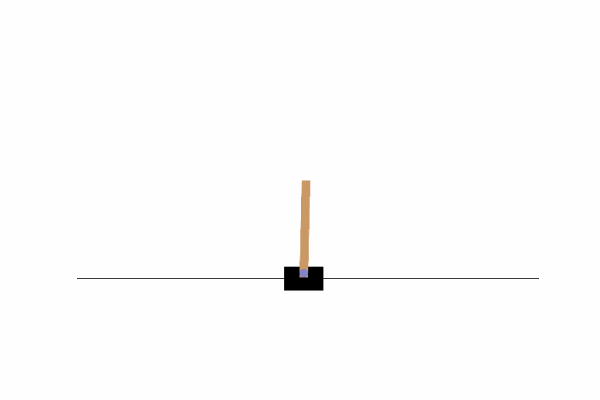

In [27]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

actor = carry[0]

env = gym.make(env_name, render_mode="rgb_array")

obs, _ = env.reset()
frames = []
for t in tqdm(range(500)):
    frames.append(env.render())
    action = agent.suggest_action(jnp.expand_dims(obs, 0), actor)[0]
    obs, _, done, _, _ = env.step(action.item())
    if done:
        break
        
env.close()

save_frames_as_gif(frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())